In [1]:
!python --version

Python 3.10.9


In [2]:
import matplotlib.pyplot as plt
import matplotlib.tri    as tri
import numpy             as np
import scipy             as sp
import os

# About ADELI's p-file

A Pfile is the standard output of the ADELI software. The first issue is to represent the file and its structure in a Python fasion.

In [3]:
class Pfile():

    def __init__(self, path: str) -> None:
        self.path = path
        self.__read_header()
        
        return None
    

    def __read_header(self) -> None:

        fields   = []
        topology = []

        try:
            with open(self.path, "r") as stream:
                
                # Read fields related informations
                number = int(stream.readline().strip())
                for _ in range(number):
                    fields.append(stream.readline().strip())

                # Read topology related informations
                next(stream)
                topology = np.int_(list(filter(None, stream.readline().strip().split(" "))))

                # Update object attributes
                self.nfields = len(fields)
                self.fields  = fields

                self.nelem = topology[0]
                self.nvert = topology[1]
                self.ngaus = topology[2]
                self.ndime = topology[3]
                self.nface = topology[4]
                self.npres = topology[5]

                self.offset = 1 +self.nfields +3 +self.nelem +1 +(self.npres//10 +1) +1 +self.nface +2

        except FileNotFoundError:
            print(f"{self.path} is not readable, skip.")
        
        return None
    

    def read_elements(self) -> np.ndarray:
        elements = None

        try:
            elements = np.loadtxt( self.path,
                                   dtype=int,
                                   skiprows=(4 +self.nfields),
                                   max_rows=self.nelem )
            elements = elements[:, 1:]
        
        except FileNotFoundError:
            print(f"{self.path} is not readable, skip.")

        return elements
    

    def read_contour(self) -> np.ndarray:
        # contour = None

        # try:
        #     contour = np.genfromtxt( self.path,
        #                               dtype=int,
        #                               skip_header=(4 +self.nfields +self.nelem +1),
        #                               skip_footer=(self.npres//10 +1) )
        #     contour = contour.flatten()

        # except FileNotFoundError:
        #     print(f"{self.path} is not readable, skip.")

        # return contour
        raise NotImplementedError


    def read_faces(self) -> np.ndarray:
        faces = None

        try:
            faces = np.loadtxt( self.path,
                                dtype=int,
                                skiprows=(4 +self.nfields +self.nelem +1 +int(self.npres//10 +1) +1),
                                max_rows=self.nface )
            faces = faces[:, 1:]

        except FileNotFoundError:
            print(f"{self.path} is not readable, skip.")

        return faces
    

    def read_coords(self, dates: list, names: list) -> np.ndarray:
        coords = np.zeros((len(dates), len(names), self.nvert)) *float('nan')

        coordsmap = { 'x' : 1, 'y' : 2, 'z' : 3,
                      'vx': 4, 'vy': 5, 'vz': 6,
                      'ux': 7, 'uy': 8, 'uz': 9,
                      'T' : 10 }
        
        try:
            for i, n in enumerate(dates):
                coords[i, :, :] = np.loadtxt( self.path, 
                                              dtype=float,
                                              skiprows=(self.offset +n*(self.nvert + self.nelem +3)),
                                              max_rows=self.nvert,
                                              usecols=[coordsmap[name] for name in names] ).transpose()
        
        except FileNotFoundError:
            print(f"{self.path} is not readable, skip.")

        return coords
    

    def read_fields(self, dates: list, names: list) -> np.ndarray:
        fields = np.zeros((len(dates), len(names), self.nelem)) *float('nan')

        fieldsmap = dict(
            zip(
                    [name for name in self.fields],
                    [self.fields.index(name)+1 for name in self.fields] 
               )
        )

        try:
            for i, n in enumerate(dates):
                fields[i, :, :] = np.loadtxt( self.path,
                                              dtype=float,
                                              skiprows=(self.offset +n*(self.nelem +3) +(n+1)*self.nvert),
                                              max_rows=self.nelem,
                                              usecols=[fieldsmap[name] for name in names] ).transpose()
                
        except FileNotFoundError:
            print(f"{self.path} is not readable, skip.")

        return fields

For now, the linear contour of the materials does not work, it is not implemented, even if it appears in the structure. However, it is not used yet, so I leave the question out for the moment.

# Declare an instance of the class `Pfile`

In [4]:
basepath  = os.path.join("C:\\Users", "julie", "Documents", "test_deia_Nov2022")
expfolder = "E11_rect_P2_0.5GPa_init0_neigh1_time10_dtup5000_500000_1000K_Zfree_WR7_4e_6_PNew1.5e9_long"
exppath   = os.path.join(basepath, expfolder)

ppath = os.path.join(exppath, "".join([filename for filename in os.listdir(exppath) if filename.startswith("p")]))
pfile = Pfile(ppath)

Check its attributs

In [5]:
pfile.__dict__

{'path': 'C:\\Users\\julie\\Documents\\test_deia_Nov2022\\E11_rect_P2_0.5GPa_init0_neigh1_time10_dtup5000_500000_1000K_Zfree_WR7_4e_6_PNew1.5e9_long\\pcompr',
 'nfields': 24,
 'fields': ['s_xx',
  's_yy',
  's_zz',
  's_xy',
  's_yz',
  's_zx',
  'e_xx',
  'e_yy',
  'e_zz',
  'e_xy',
  'e_yz',
  'e_zx',
  'd_xx',
  'd_yy',
  'd_zz',
  'd_xy',
  'd_yz',
  'd_zx',
  'plast_eq',
  'jplas',
  'xplas',
  'T',
  'viscosite eff.',
  'Peierls'],
 'nelem': 94989,
 'nvert': 26832,
 'ngaus': 4,
 'ndime': 3,
 'nface': 44428,
 'npres': 956,
 'offset': 139545}

# About the topology

One may now access to the topology of the simulation : ADELI computes the evolution of a system described by continuum mechanics and thermics coupling in a finite element way. The domain is a fake 2.D surface : actually it is described by two rectangular surfaces and a depth of one element. The topology describes the adjacency of the vertices, and is constant through the simulation. Topology is actually a connectivity table : one tetrahedron is completely determined by four vertices. The first integer is the index of a region, of a subdomain, physically a precise material.

In [6]:
conn = pfile.read_elements()

print(f"shape     : {conn.shape}")
print(f"dtype     : {conn.dtype}")
print(f"NaNs      : {np.any(np.isnan(conn))}")
print(f"materials : {conn[:,0].max()}")
print()
print(f"Head :")
print(f"{conn[:5,:]}")
print()
print(f"Tail :")
print(f"{conn[-5:,:]}")

shape     : (94989, 5)
dtype     : int32
NaNs      : False
materials : 2

Head :
[[    1 24638 17982 17915 25930]
 [    1 24638 17915 17982 15156]
 [    1  5255  3962 24278 24378]
 [    1 14253 15576 24278 24378]
 [    1 11476 24260 11478 24356]]

Tail :
[[    2  9412 26468 26351 20150]
 [    2 21576 26741 21630 26799]
 [    2   632   631 26633 21576]
 [    2 26249 26570 18097   607]
 [    2 26570 21549   607 26249]]


One remarks that there are two different regions here. In the context, it means that a fake material is present and one should get rid of it during the analysis. The other case is that there is only one.

Studying the bulk behavior of the material means look at some fields on a facet of the domain. This information is stored in the Pfile with the following convention : first, the number of the facet (a facet is a boundary of the macro-subdomain $\Omega_{imat}$), then three integers that represent the index of vertices, and then the material in which the boundary is.

In [7]:
faces = pfile.read_faces()

print(f"shape  : {faces.shape}")
print(f"dtype  : {faces.dtype}")
print(f"NaNs   : {np.any(np.isnan(faces))}")
print(f"facets : {faces[:,0].max()}")
print()
print(f"Head :")
print(f"{faces[:5,:]}")
print()
print(f"Tail :")
print(f"{faces[-5:,:]}")

shape  : (44428, 5)
dtype  : int32
NaNs   : False
facets : 12

Head :
[[   1    1   17 7701    1]
 [   1  332    1 7701    1]
 [   1  115    2 7703    1]
 [   1    2  116 7703    1]
 [   1  273    3 7704    1]]

Tail :
[[   12   784   785 21884     2]
 [   12   785   786 21895     2]
 [   12   786   787 21883     2]
 [   12   787   788 21893     2]
 [   12   788   789 21886     2]]


Once again : this table is a connectivity table, constant through time. To figure out : the topology remains constant through the simulation, while the geometry (coordinates of the vertices) varies, because the simulation is computed in the lagrangian framework.

# Single timestep exploration

The two functions that read coordinates or fields share the same signature : one must give the list of index of the dates -- $n$ in $\{t_n\}_\mathbb{N}$ -- and the names of the coordinates or fields under study. For instance, I would like to draw the vertices at the initial time step $n=0$. I am in a 3D context so I must get $3$ coordinates labelled $x, y, z$.

In [8]:
dates = [0]
names = ['x', 'y', 'z']

xyz   = pfile.read_coords(dates, names)

print(f"shape   : {xyz.shape}")
print(f"dtype   : {xyz.dtype}")
print(f"NaNs    : {np.any(np.isnan(xyz))}")
print(f"x-range : [{xyz[0, 0, :].min()} ; {xyz[0, 0, :].max()}]")
print(f"y-range : [{xyz[0, 1, :].min()} ; {xyz[0, 1, :].max()}]")
print(f"z-range : [{xyz[0, 2, :].min()} ; {xyz[0, 2, :].max()}]")
print()
print(f"Head :")
print(f"{xyz[..., :5]}")
print()
print(f"Tail :")
print(f"{xyz[..., -5:]}")

shape   : (1, 3, 26832)
dtype   : float64
NaNs    : False
x-range : [-0.045 ; 0.045]
y-range : [-0.0005 ; 0.0005]
z-range : [-0.035 ; 0.035]

Head :
[[[-0.025   0.025  -0.025   0.025  -0.045 ]
  [-0.0005 -0.0005 -0.0005 -0.0005 -0.0005]
  [-0.015  -0.015   0.015   0.015  -0.035 ]]]

Tail :
[[[ 3.3896e-02  9.9698e-03  1.9083e-02 -3.5776e-02 -2.6352e-02]
  [ 3.4261e-07  9.3680e-06 -1.6672e-05 -2.9368e-06 -1.2631e-06]
  [-1.7141e-02  1.7527e-02  1.8654e-02  1.6037e-02 -7.7200e-03]]]


The fact that there is a first axis with the single coordinate $(0)$ here is for a general purpose : actually, this function reads any number of timesteps, and this first coord index that timestep. 

More precisely : `xyz[i, j, k]` is for $x_j(t_i)$ the $j$-th coordinate of timestep $i$ of the node $p_k$. In this textual representation, lines are $j \in \{0, 1, 2\}$, respectively $(x, y, z)$ and the columns are $k$, the node index, the first brackets pair has no meaning here (because it is a dimension with only one value : $0$).

It is possible to represent the nodes of the mesh.

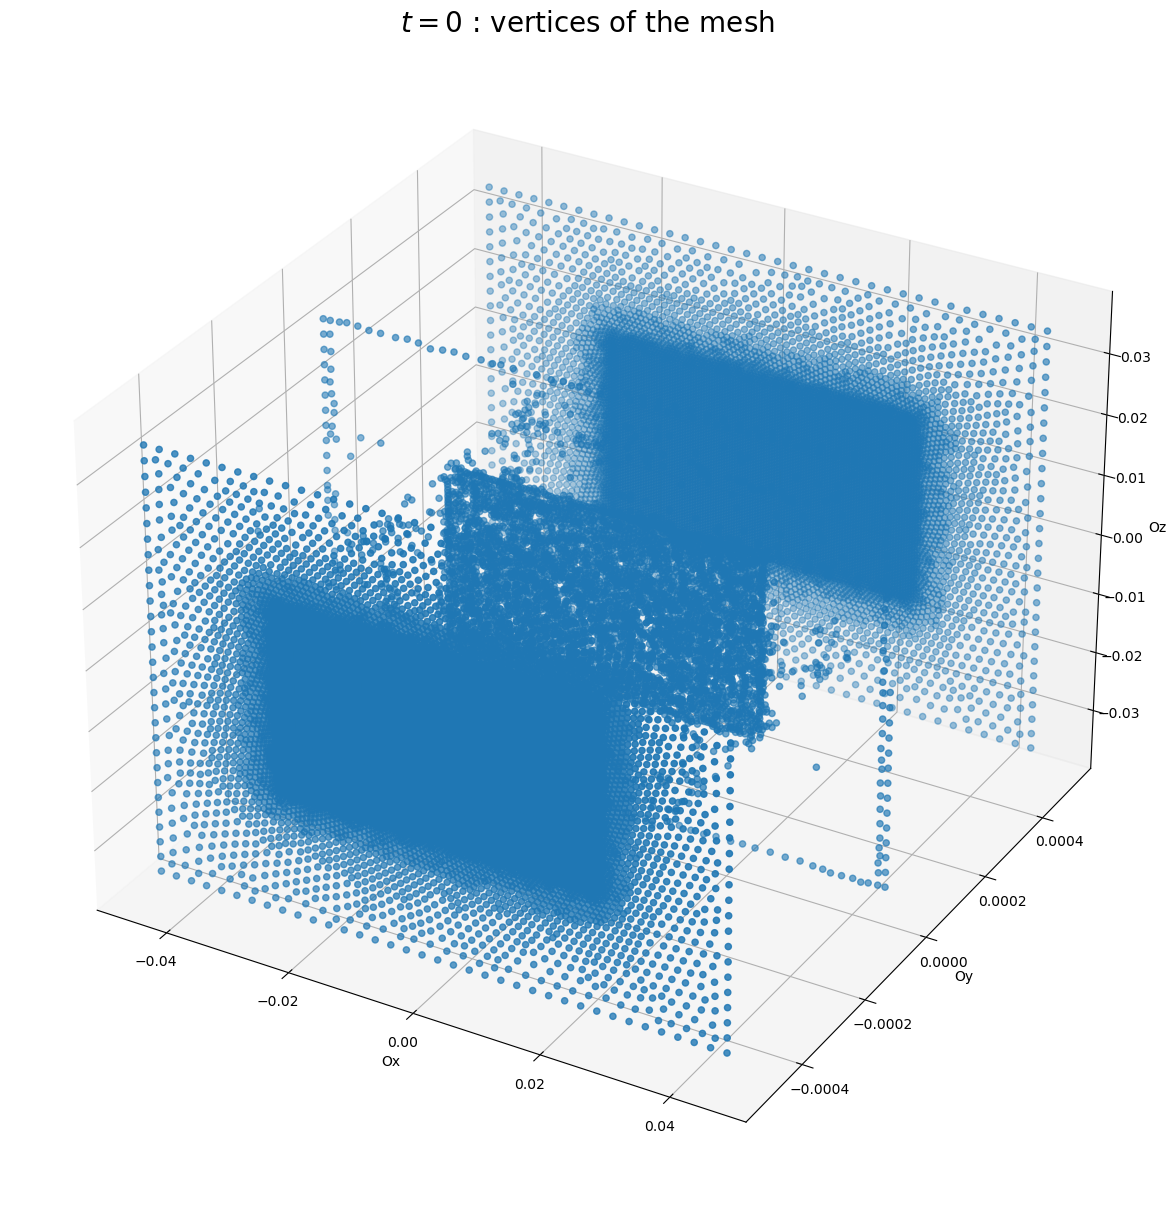

In [9]:
fig = plt.figure(figsize=(15,15))
axe = fig.add_subplot(projection='3d')

axe.scatter(xyz[0,0,:], xyz[0,1,:], xyz[0,2,:])
axe.set_title("$t=0$ : vertices of the mesh", fontsize=20)
axe.set_xlabel("Ox")
axe.set_ylabel("Oy")
axe.set_zlabel("Oz")
plt.show()

As highlighted previously, our study interests only in a single [sub]-facet of the domain. To help to identify them, let represent these facets. Remember that there is already a variable named `faces` that stores the connectivity table of the facets.

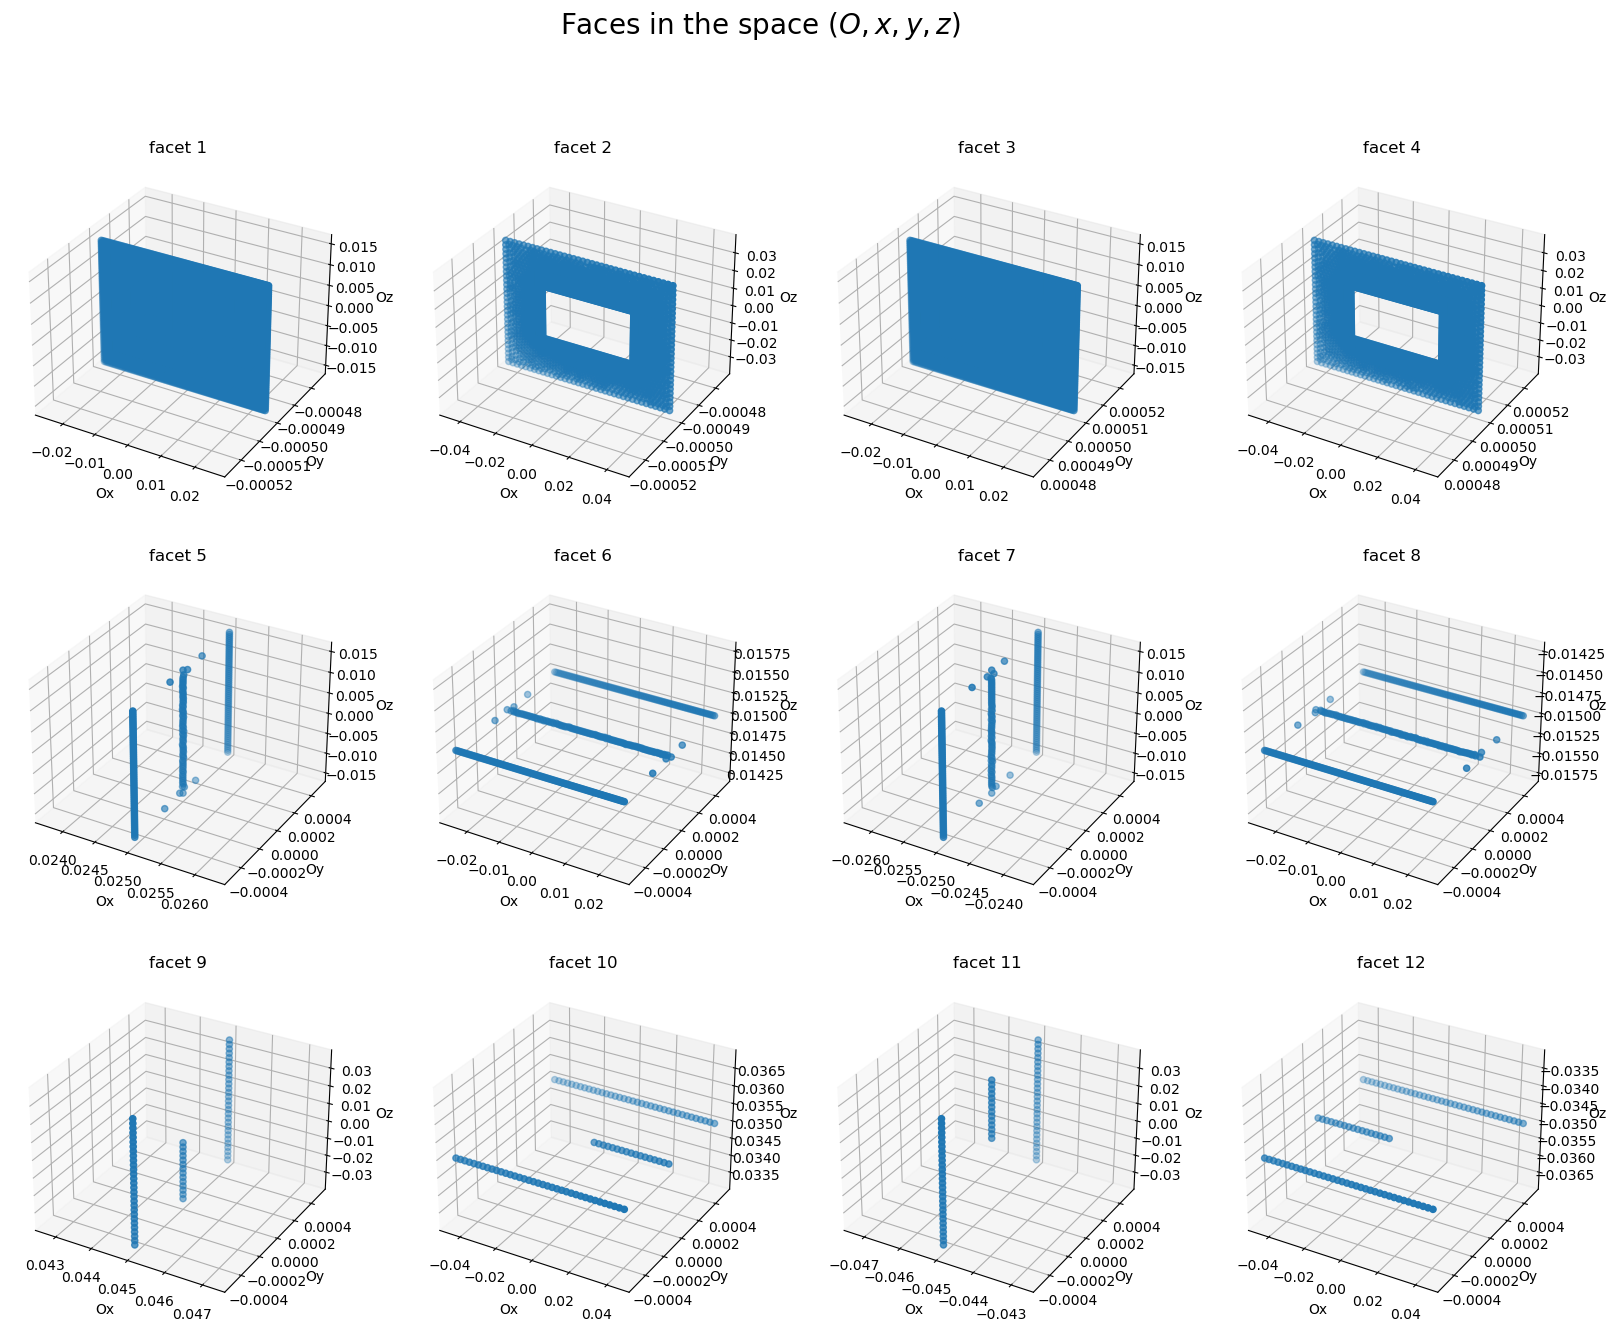

In [10]:
fig = plt.figure(figsize=(20,15))

for i in range(3):
    for j in range(4):
        index  = np.where(faces[:,0]==4*i+j+1)[0]
        idver  = np.unique(faces[index,1:4].flatten())
        coords = xyz[0, :, idver-1]

        axe = fig.add_subplot(3, 4, 4*i+j+1, projection='3d')
        axe.scatter(coords[:,0], coords[:,1], coords[:,2])
        axe.set_title(f"facet {4*i+j+1}")
        axe.set_xlabel("Ox")
        axe.set_ylabel("Oy")
        axe.set_zlabel("Oz")

plt.suptitle("Faces in the space $(O, x, y, z)$", fontsize=20)
plt.show()

Clearly, the facets of interest are the first or the third.

The next question is to build the 2D mesh associated to a facet. One already has access to the vertices of these facets. The aim is to build a Delaunay triangulation of this cloud of points. To achieve this, one can use a built-in data structure with its methods like `matplotlib.tri.Triangulation` or `scipy.spatial.Delaunay`. In the following cell, I use the fact that the first facet is constrained by $y \in \mathbb{R}$ so I choose to forget this coordinate and to work in $(O,x,z)$ plane.

`xyz` shape : (1, 3, 26832)
`xz`  shape : (3, 7154)


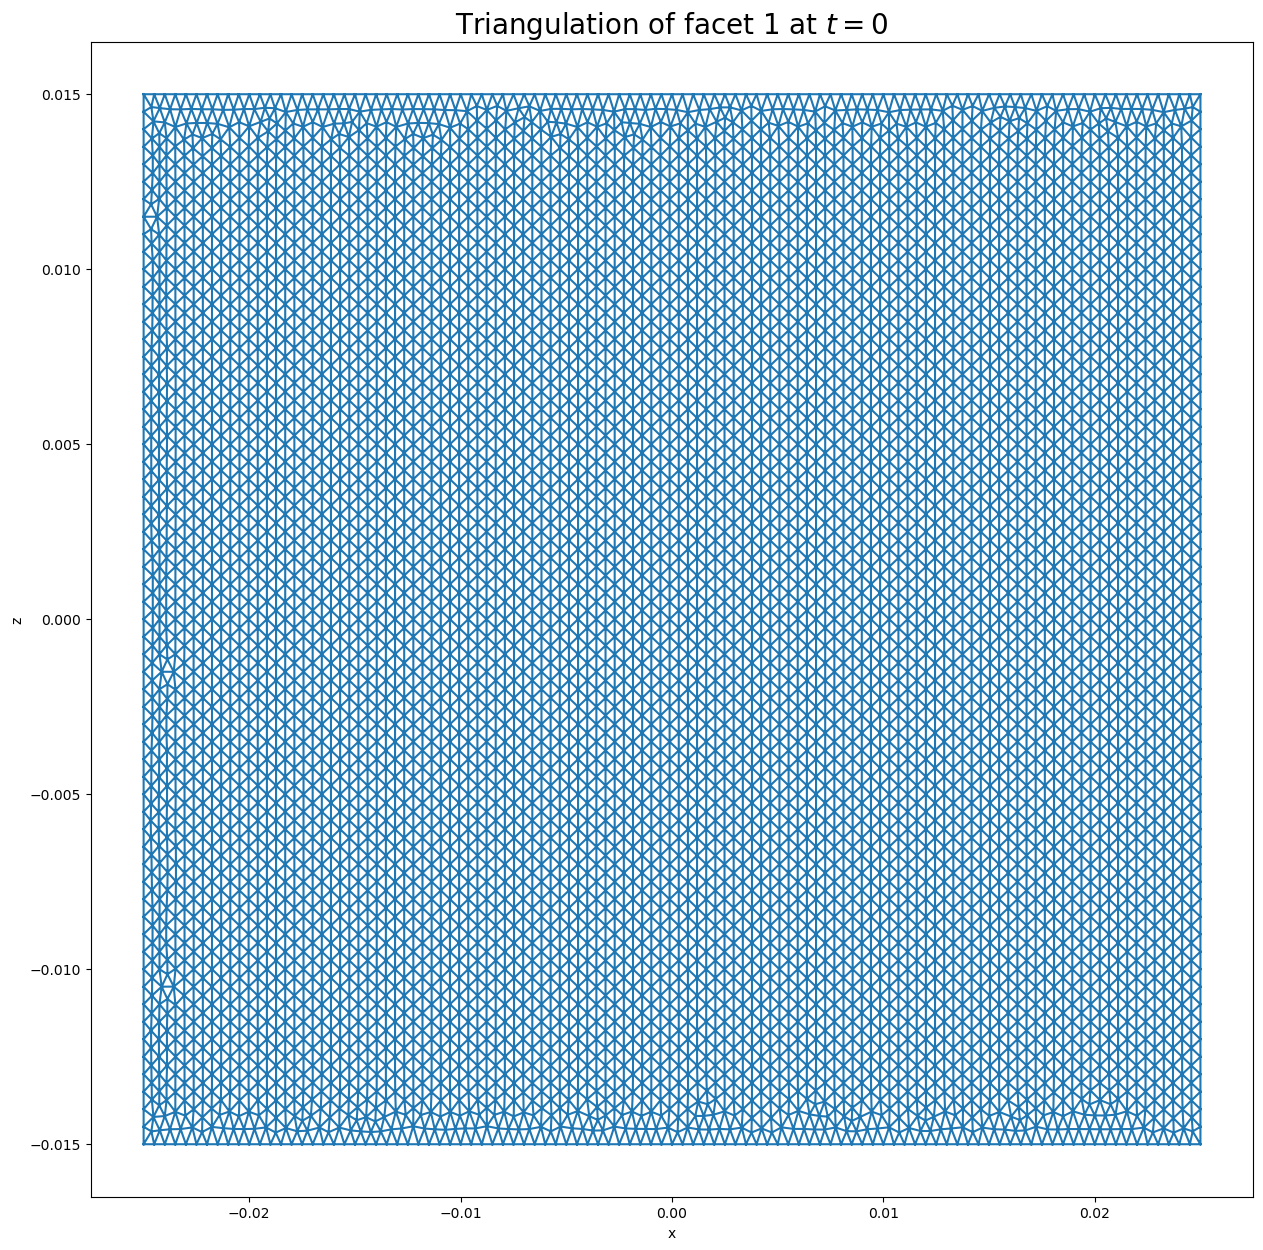

In [11]:
index = np.where(faces[:,0]==1)[0]
ids   = np.unique(faces[index,1:4].flatten())
xz    = xyz[0, :, ids-1].transpose()

print(f"`xyz` shape : {xyz.shape}")
print(f"`xz`  shape : {xz.shape}")

mesh  = tri.Triangulation(xz[0,:], xz[2,:])

fig = plt.figure(figsize=(15,15))

axe = fig.add_subplot(1, 1, 1)
axe.triplot(mesh)
axe.set_title("Triangulation of facet $1$ at $t=0$", fontsize=20)
axe.set_xlabel("x")
axe.set_ylabel("z")

plt.show()

Here it is for topological considerations. Now we would like to represent a field on that mesh. The representation of node-defined fields, like coordinates, is immediate with this representation. For instance, it is possible to visualise temperature (as stored in the coordinates, not the element-defined field).

`T` shape : (1, 1, 26832)
`t` shape : (7154,)


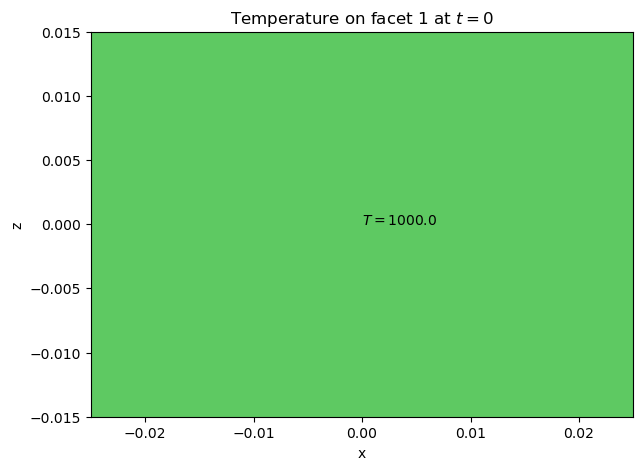

In [12]:
T = pfile.read_coords([0], ['T'])
t = T[0, 0, ids-1]

print(f"`T` shape : {T.shape}")
print(f"`t` shape : {t.shape}")

fig = plt.figure(figsize=(7, 5))

axe = fig.add_subplot(1, 1, 1)
plot = axe.tricontourf(mesh, t)
axe.text(x=0., y=0., s=f"$T={t[0]}$")
axe.set_title("Temperature on facet $1$ at $t=0$")
axe.set_xlabel("x")
axe.set_ylabel("z")

plt.show()

Obviously, the initialization is constant, so the plot is not that interesting... Considere this is a proof of concept. A real question here is to set a colormap (and a colorbar) that suits to the context of constant data.

It is possible to plot a single or multiple fields for a single timestep. The function that reads field values has the same signature as `pfile.read_coord(dates: list, names: list)`. For instance, one can read every scalar field that define $\sigma$, the strain. They are six, assembled in the de Voigt representation.

In [13]:
dates = [0]
names = ['s_xx', 's_yy', 's_zz', 's_xy', 's_yz', 's_zx']

sigma = pfile.read_fields(dates, names)

print(f"shape  : {sigma.shape}")
print(f"dtype  : {sigma.dtype}")
print(f"NaNs   : {np.any(np.isnan(sigma))}")
print(f"min    :\n{sigma.min(axis=2)}")
print(f"max    :\n{sigma.max(axis=2)}")
print(f"mean   :\n{sigma.mean(axis=2)}")
print(f"std    :\n{sigma.std(axis=2)}")
print()
print(f"Head :")
print(f"{sigma[0, :, :5]}")
print(f"Tail :")
print(f"{sigma[0, :, -5:]}")

shape  : (1, 6, 94989)
dtype  : float64
NaNs   : False
min    :
[[0. 0. 0. 0. 0. 0.]]
max    :
[[0. 0. 0. 0. 0. 0.]]
mean   :
[[0. 0. 0. 0. 0. 0.]]
std    :
[[0. 0. 0. 0. 0. 0.]]

Head :
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Tail :
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


The next step is to compute invariants for the strain $\sigma$, in particular $I_{2|\sigma}$ and $J_{2|\sigma}$. These are two scalar fields invariant by diffeomorphism for the tensor field $\sigma$, this is the information of the physical state. They are defined on each element of the mesh.

In [14]:
print(pfile.fields[:6])

['s_xx', 's_yy', 's_zz', 's_xy', 's_yz', 's_zx']


In [15]:
i2s = np.sqrt(   np.power(sigma[0, :3, :], 2).sum(axis=0)    \
               + 2 *np.power(sigma[0, 3:, :], 2).sum(axis=0) )

print(f"shape : {i2s.shape}")
print(f"dtype : {i2s.dtype}")
print(f"NaNs  : {np.any(np.isnan(i2s))}")
print(f"min   : {i2s.min()}")
print(f"max   : {i2s.max()}")
print(f"mean  : {i2s.mean()}")
print(f"std   : {i2s.std()}")
print()
print("Head :")
print(f"{i2s[:5]}")
print()
print("Tail :")
print(f"{i2s[-5:]}")

shape : (94989,)
dtype : float64
NaNs  : False
min   : 0.0
max   : 0.0
mean  : 0.0
std   : 0.0

Head :
[0. 0. 0. 0. 0.]

Tail :
[0. 0. 0. 0. 0.]


In [16]:
p   = sigma[0, :3, :].sum(axis=0) /3.0

j2s = np.sqrt(   3./2 *np.power(sigma[0, :3, :] -1./3*p, 2).sum(axis=0) \
               + 3. *np.power(sigma[0, 3:, :], 2).sum(axis=0)           )

print(f"shape : {j2s.shape}")
print(f"dtype : {j2s.dtype}")
print(f"NaNs  : {np.any(np.isnan(j2s))}")
print(f"min   : {j2s.min()}")
print(f"max   : {j2s.max()}")
print(f"mean  : {j2s.mean()}")
print(f"std   : {j2s.std()}")
print()
print("Head :")
print(f"{j2s[:5]}")
print()
print("Tail :")
print(f"{j2s[-5:]}")

shape : (94989,)
dtype : float64
NaNs  : False
min   : 0.0
max   : 0.0
mean  : 0.0
std   : 0.0

Head :
[0. 0. 0. 0. 0.]

Tail :
[0. 0. 0. 0. 0.]


These two algorithms apply to any tensor field represented by its De Voigt vector. 

Finally, the goal is to draw a picture of these last fields. The underlying question is to represent an element-defined scalar field in a nodal mode, so that it becomes possible to use a plot function like `matplotlib.pyplot.tricontourf` to get a picture built on a spatial interpolation of this field on the mesh. The value of the field at one node is computed as the sum of the values in any element which has the particular node as a vertex.

First, let build the *reverse* table of the topology : to each node of the first facet, represented by a key of a dictionary, associate the list of indices of the elements related to this node. One can not use a `numpy.ndarray` because the number of elements is not constant for each nodes.

In [17]:
vals = []
for _ in range(len(ids)):
    vals.append([])

reverse = dict(
    zip(
         ids,
         vals
    )
)

for i, el in enumerate(conn[:, 1:]):
    for p in el:
        if p in ids:
            reverse[p].append(i)

# Examples
print("Node id\t\t\t\t\t\t\t\t\tList of elements")
print("-------\t\t\t\t\t\t\t\t\t----------------")
for p in ids[:10]:
    print(str(p).zfill(2), "\t|-->\t", reverse[p])

print(".", "\t.\t", ".")
print(".", "\t.\t", ".")
print(".", "\t.\t", ".")

Node id									List of elements
-------									----------------
01 	|-->	 [2541, 26351, 26363, 66320, 66321, 66329, 68571, 68690, 68704, 68981, 69884, 69900, 71490, 77436, 83611, 83765, 88198, 93902, 93905, 94262]
02 	|-->	 [8570, 46129, 49616, 66322, 66324, 66331, 71921, 71992, 75969, 77156, 78255, 79387, 81122, 81435, 81460, 87621, 87832, 93097, 93625, 93864]
03 	|-->	 [18560, 18638, 48067, 66318, 66332, 66333, 69690, 69966, 77967, 78522, 81502, 86468, 88066, 89820, 93636, 93640, 94087, 94090]
04 	|-->	 [18223, 18548, 46285, 66330, 66339, 66340, 73022, 73256, 75340, 78082, 79197, 85677, 85709, 88773, 93972, 93974, 94004, 94006]
17 	|-->	 [2442, 2541, 63311, 63467, 65274, 65363, 66231, 66320, 81494, 82210, 88198, 89185, 91457, 93905, 94870, 94875]
18 	|-->	 [32357, 48000, 65226, 65261, 65274, 66231, 68274, 68278, 70544, 72476, 72872, 77535, 79058, 89185, 94875, 94876]
19 	|-->	 [58954, 63420, 63500, 64002, 65226, 65493, 65721, 65835, 68277, 68278, 68623, 68667, 72476, 77535, 77981, 

One is now able to slice efficiently the values of a field.

In [18]:
i2s_ = np.asarray([i2s[reverse[id]].sum()/len(reverse[id]) for id in ids], dtype=np.float64)

print(f"shape : {i2s_.shape}")
print(f"dtype : {i2s_.dtype}")
print(f"NaNs  : {np.any(np.isnan(i2s_))}")
print(f"min   : {i2s_.min()}")
print(f"max   : {i2s_.max()}")
print(f"mean  : {i2s_.mean()}")
print(f"std   : {i2s_.std()}")

shape : (7154,)
dtype : float64
NaNs  : False
min   : 0.0
max   : 0.0
mean  : 0.0
std   : 0.0


Shall I plot ?

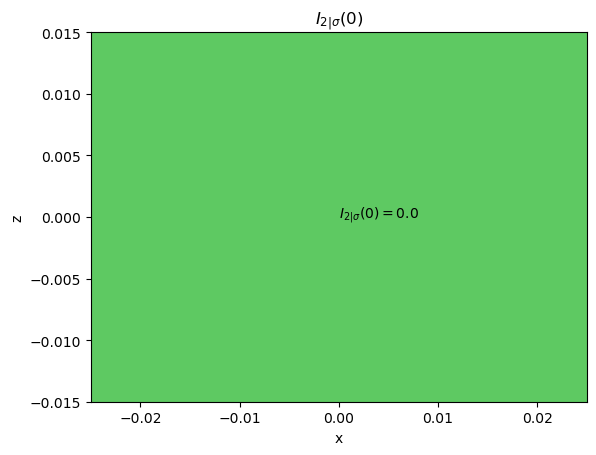

In [19]:
fig = plt.figure()

axe = fig.add_subplot(1, 1, 1)
g = axe.tricontourf(mesh, i2s_)
axe.text(x=0., y=0., s="$I_{2|\sigma}(0)=$"+f"${i2s_[0]}$")
axe.set_title("$I_{2|\sigma}(0)$")
axe.set_xlabel("x")
axe.set_ylabel("z")

# plt.colorbar(g)
plt.show()

shape : (7154,)
dtype : float64
NaNs  : False
min   : 0.0
max   : 0.0
mean  : 0.0
std   : 0.0


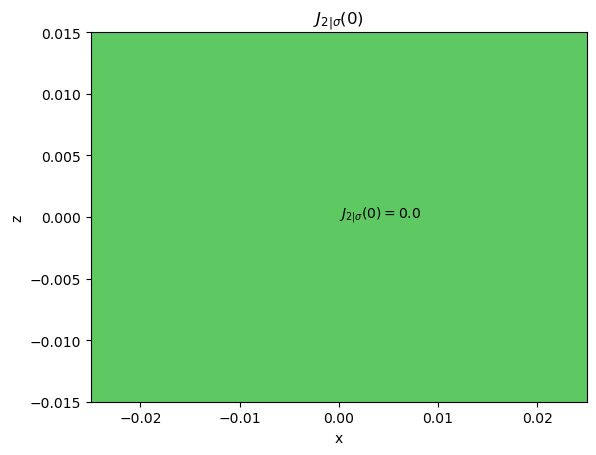

In [20]:
j2s_ = np.asarray([j2s[reverse[id]].sum()/len(reverse[id]) for id in ids], dtype=np.float64)

print(f"shape : {j2s_.shape}")
print(f"dtype : {j2s_.dtype}")
print(f"NaNs  : {np.any(np.isnan(j2s_))}")
print(f"min   : {j2s_.min()}")
print(f"max   : {j2s_.max()}")
print(f"mean  : {j2s_.mean()}")
print(f"std   : {j2s_.std()}")

fig = plt.figure()
axe = fig.add_subplot(1, 1, 1)
g = axe.tricontourf(mesh, j2s_)
axe.text(x=0., y=0., s="$J_{2|\sigma}(0)=$"+f"${j2s_[0]}$")
axe.set_title("$J_{2|\sigma}(0)$")
axe.set_xlabel("x")
axe.set_ylabel("z")
# plt.colorbar(g)
plt.show()

Let build a regular grid associated to the 2D triangulation of the facet. To build the 2D lattice, I choose to introduce $1024$ nodes by dimension.

In [21]:
xlin = np.linspace(xz[0,:].min(), xz[0,:].max(), 1024, endpoint=True)
zlin = np.linspace(xz[2,:].min(), xz[2,:].max(), 1024, endpoint=True)

xgrid, zgrid = np.meshgrid(xlin, zlin)

print(f"         `xgrid`\t`zgrid`")
print(f"shape : {xgrid.shape}\t{zgrid.shape}")
print(f"dtype : {xgrid.dtype}\t\t{zgrid.dtype}")

         `xgrid`	`zgrid`
shape : (1024, 1024)	(1024, 1024)
dtype : float64		float64


In [22]:
print(xgrid[:, :5])

[[-0.025      -0.02495112 -0.02490225 -0.02485337 -0.0248045 ]
 [-0.025      -0.02495112 -0.02490225 -0.02485337 -0.0248045 ]
 [-0.025      -0.02495112 -0.02490225 -0.02485337 -0.0248045 ]
 ...
 [-0.025      -0.02495112 -0.02490225 -0.02485337 -0.0248045 ]
 [-0.025      -0.02495112 -0.02490225 -0.02485337 -0.0248045 ]
 [-0.025      -0.02495112 -0.02490225 -0.02485337 -0.0248045 ]]


In [23]:
print(xgrid[:5, :])

[[-0.025      -0.02495112 -0.02490225 ...  0.02490225  0.02495112
   0.025     ]
 [-0.025      -0.02495112 -0.02490225 ...  0.02490225  0.02495112
   0.025     ]
 [-0.025      -0.02495112 -0.02490225 ...  0.02490225  0.02495112
   0.025     ]
 [-0.025      -0.02495112 -0.02490225 ...  0.02490225  0.02495112
   0.025     ]
 [-0.025      -0.02495112 -0.02490225 ...  0.02490225  0.02495112
   0.025     ]]


shape : (1024, 1024)
dtype : float64
NaNs  : False
min   : 0.0
max   : 0.0
mean  : 0.0
std   : 0.0


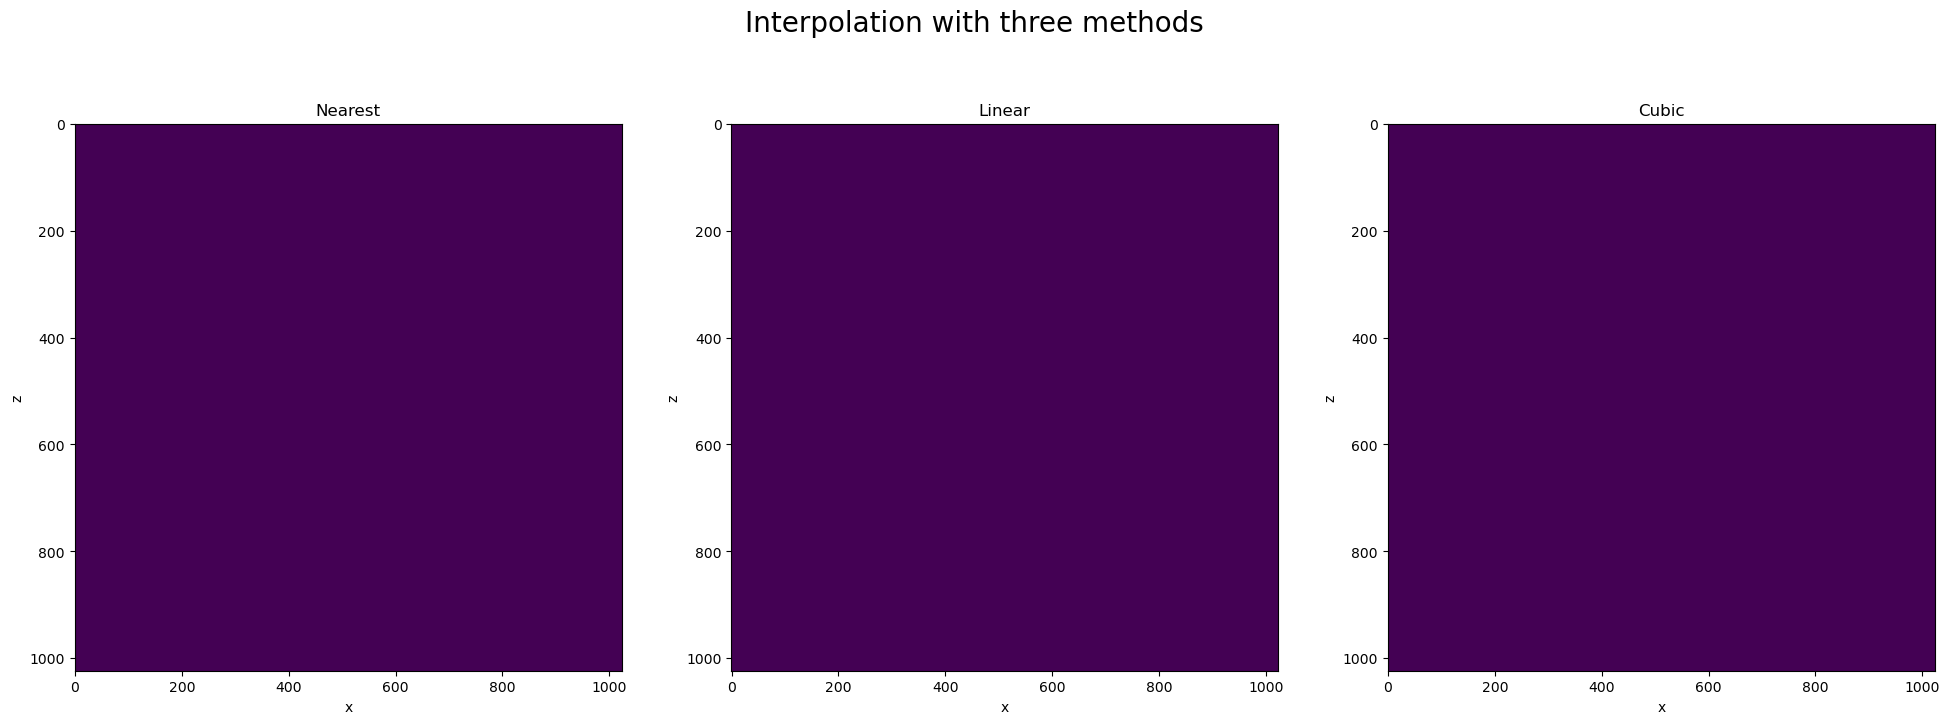

In [24]:
ii2sn = sp.interpolate.griddata( np.swapaxes(xz[[0,2], :], axis1=1, axis2=0), i2s_[:], (xgrid, zgrid), method='nearest' )
ii2sl = sp.interpolate.griddata( np.swapaxes(xz[[0,2], :], axis1=1, axis2=0), i2s_[:], (xgrid, zgrid), method='linear' )
ii2sc = sp.interpolate.griddata( np.swapaxes(xz[[0,2], :], axis1=1, axis2=0), i2s_[:], (xgrid, zgrid), method='cubic' )

print(f"shape : {ii2sc.shape}")
print(f"dtype : {ii2sc.dtype}")
print(f"NaNs  : {np.any(np.isnan(ii2sc))}")
print(f"min   : {np.nanmin(ii2sc)}")
print(f"max   : {np.nanmax(ii2sc)}")
print(f"mean  : {np.nanmean(ii2sc)}")
print(f"std   : {np.nanstd(ii2sc)}")

fig = plt.figure(figsize=(24,8))

axe = fig.add_subplot(1, 3, 1)
axe.imshow(ii2sn)
axe.set_xlabel("x")
axe.set_ylabel("z")
axe.set_title("Nearest")

axe = fig.add_subplot(1, 3, 2)
axe.imshow(ii2sl)
axe.set_xlabel("x")
axe.set_ylabel("z")
axe.set_title("Linear")

axe = fig.add_subplot(1, 3, 3)
axe.imshow(ii2sc)
axe.set_xlabel("x")
axe.set_ylabel("z")
axe.set_title("Cubic")

plt.suptitle("Interpolation with three methods", fontsize=20)
plt.show()

Here are images on which image analysis is possible. The very first goal that is to read and to pre-processing ADELI's output ends here.

# Multiple timesteps exploration

As a conclusion of this notebook let read all the fields for all timesteps. In the sample file, it is known that there are $21$ steps, but in general, it is the length of the list given by the instance of `Tfile.read()`.

In [25]:
dates = list(range(21))
names = pfile.fields

coordi = pfile.read_coords(dates, ['x', 'y', 'z'])
fields = pfile.read_fields(dates, names)

print("Information about coordinates")
print("-----------------------------")
print(f"shape : {coordi.shape}")
print(f"dtype : {coordi.dtype}")
print(f"NaNs  : {np.any(np.isnan(coordi))}")
print()
print("Information about fields")
print("------------------------")
print(f"shape : {fields.shape}")
print(f"dtype : {fields.dtype}")
print(f"NaNs  : {np.any(np.isnan(fields))}")

Information about coordinates
-----------------------------
shape : (21, 3, 26832)
dtype : float64
NaNs  : False

Information about fields
------------------------
shape : (21, 24, 94989)
dtype : float64
NaNs  : False


This last cell is executed in less than $50$ seconds on my personal laptop.

One recovers a single timestep by slicing along the first axis : `coordi[n,...]` and `fields[n,...]`.

--- 

# Take home message

The data path from ADELI's `p`-file to a picture that is analysable by image processing is the following :

- choose an experience, that is a unique folder
- declare an instance of `Pfile` thanks to the **absolute path** to the `p`-file
- read the faces under interest : it is a 2D-array with, for each line (= triangle) : the id of the facet, three ids of points, then the id of the material. So I finally have the triangulation !

## For a single timestep pre-processing :

- call `pfile.read_coords()` to access the coordinates
- slice these coordinates with the list of unique vertices ids
- rebuild the triangulation
- read the field under interest
- if this field is a tensor one : compute its invariants, else continue
- compute the nodal representation of the field
- create the lattice that defines the regular grid
- interpolate with `scipy.interpolate.griddata()` on that lattice
- interprete this interpolation as the end picture.

## For several timesteps :

The implementation of reading functions allows to read several timesteps at once, so just call `pfile.read_coords()` and `read_fields()` with the list of index of the dates you want to work with.